# Store Trial Testing

In [312]:
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np

## Data Loading

In [198]:
df = pd.read_csv('QVI_data.csv')

In [199]:
for i in range(len(df)):
    df.loc[i, 'date'] = df.loc[i, 'DATE'][:-3]

In [201]:
df_store = df.groupby(['STORE_NBR', 'date']).sum()[['TOT_SALES']]
df_store['customer'] = df.groupby(['STORE_NBR', 'date']).count()[['TXN_ID']]
df_store['avg_sales'] = df_store.TOT_SALES / df_store.customer

## Control Stores Selection

In this section, I will select control stores for each trial store (i.e., store 77, 86, and 88). The control store should have the same operation period as the trial store. Moreover, the control store should be the most similar store to the trial store in terms of total sales per month, the number of customers per month, and the average sales per customer per month. Therefore, I decided to find the store with the largest Pearson correlation with the trial store in terms of the three metrics.

In [212]:
pre = ['2018-07', '2018-08', '2018-09', '2018-10', 
          '2018-11', '2018-12', '2019-01'
         ]
# define a function to calculate correlation
def corr_(num1: int, num2: int, metrics: str) -> float:
    return df_store.loc[num1].loc[pre, metrics].\
       corr(df_store.loc[num2].loc[pre, metrics])

In [213]:
# create a list of store number that operates for one year
lst = []
for i in range(1, 273):
    if len(df_store.loc[i]) == 12:
        lst.append(i)

In [214]:
# create a list containing the Pearson correlation for each store
corr = []
for i in lst:
    corr.append((i, corr_(77, i, 'TOT_SALES') + corr_(77, i, 'customer')))
corr = sorted(corr, key=lambda x: x[1], reverse=True)
msg = 'The control store for Store 77 is Store ' + str(corr[1][0])
print(msg)

The control store for Store 77 is Store 233


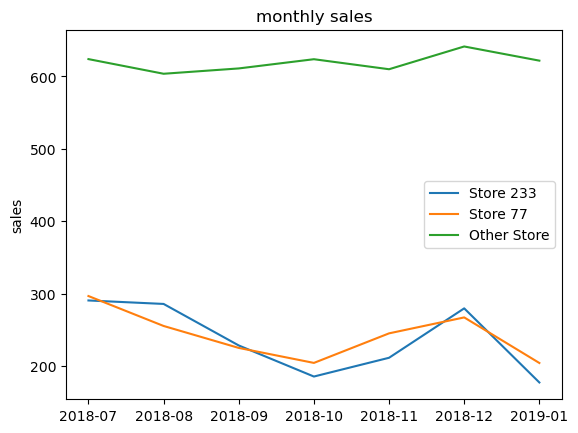

In [241]:
other = df_store.drop([77, 233])
other = other.groupby('date').mean()
plt.plot(df_store.loc[233].loc[pre]['TOT_SALES'], label='Store 233')
plt.plot(df_store.loc[77].loc[pre]['TOT_SALES'], label='Store 77')
plt.plot(other.loc[pre, 'TOT_SALES'], label='Other Store')
plt.title('monthly sales')
plt.ylabel('sales')
plt.legend()
plt.show()

## Trial Test

In the last section, I found that store 233 is a control store for trial store 77. In this section, I want to test whether the store trial makes a statistically significant improvement in chip sales. 

To ensure that the trial store and control store is comparable, I multiply the control store's monthly sales by a scaler, by which it will have exactly the same average pre-trial monthly sales as the trial store. Since I assume that there is no difference between pre-trial and post-trial monthly sales, I can use the standard deviation in the pre-trial period in my calculation. 

In [279]:
# ensure that the trial store and control store have same pre_trial monthly total sales
scale = sum(df_store.loc[(77, pre), 'TOT_SALES']) / sum(df_store.loc[(233, pre), 'TOT_SALES'])
std = (df_store.loc[77].loc[pre]['TOT_SALES'] - df_store.loc[233].loc[pre]['TOT_SALES']).std()

In [302]:
# define a function to calculate t_statistics
def t_test(avg1, avg2, std):
    return (avg1 - avg2) / std

In [307]:
trial = ['2019-02', '2019-03', '2019-04']
lst = []
for mon in trial:
    avg1 = df_store.loc[(77, mon), 'TOT_SALES']
    avg2 = df_store.loc[(233, mon), 'TOT_SALES'] * scale
    lst.append((mon, t_test(avg1, avg2, std)))
lst

[('2019-02', -0.6471349504599114),
 ('2019-03', 3.2744558387483678),
 ('2019-04', 4.434204176179327)]

Based on the t-statistics, it is obvious that the trial store has a huge improvement in monthly sales during the trial period because the t-statistics are fairly high. The results can be better shown utilizing a line graph. 

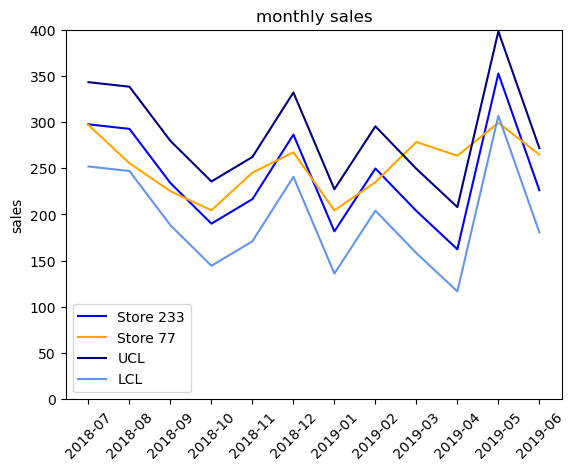

In [327]:
plt.plot(df_store.loc[233]['TOT_SALES'] * scale, label='Store 233', color='blue')
plt.plot(df_store.loc[77]['TOT_SALES'], label='Store 77', color='orange')
plt.plot(df_store.loc[233]['TOT_SALES'] * scale + \
         2 * std, label='UCL', color='navy')
plt.plot(df_store.loc[233]['TOT_SALES'] * scale - \
         2 * std, label='LCL', color='cornflowerblue')
plt.ylim(0, 400)
plt.title('monthly sales')
plt.legend()
plt.ylabel('sales')
plt.xticks(rotation=45)
plt.show()